In [5]:
import numpy as np
import pandas as pd

In [6]:
df = pd.read_csv('/kaggle/input/bank-transaction-dataset-for-fraud-detection/bank_transactions_data_2.csv')
df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [7]:
df.shape

(2512, 16)

In [47]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'])

df['TransactionHour'] = df['TransactionDate'].dt.hour
df['DaysSinceLastTx'] = (
    df['TransactionDate'] - df['PreviousTransactionDate']
).dt.total_seconds() / (60 * 60 * 24)

# Select features for iForest
features = [
    'TransactionAmount',
    'TransactionDuration',
    'LoginAttempts',
    'AccountBalance',
    'CustomerAge',
    'TransactionHour',
    'DaysSinceLastTx'
]

# Handle missing values
X = df[features].fillna(0)

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [49]:
from sklearn.ensemble import IsolationForest

# Initialize and fit the model
iso = IsolationForest(n_estimators=100, contamination=0.03, random_state=42)
df['is_anomaly'] = iso.fit_predict(X_scaled)  # -1 = anomaly, 1 = normal

In [50]:
# Count and view anomalies
print(df['is_anomaly'].value_counts())
print(df[df['is_anomaly'] == -1].head())

df[df['is_anomaly'] == -1].to_csv("anomalies.csv", index=False)

is_anomaly
 1    2436
-1      76
Name: count, dtype: int64
    TransactionID AccountID  TransactionAmount     TransactionDate  \
23       TX000024   AC00453             345.84 2023-05-02 18:25:46   
26       TX000027   AC00441             246.93 2023-04-17 16:37:01   
146      TX000147   AC00385             973.39 2023-08-30 17:23:20   
147      TX000148   AC00161             514.95 2023-04-13 18:37:48   
176      TX000177   AC00363            1362.55 2023-02-10 18:07:07   

    TransactionType    Location DeviceID      IP Address MerchantID Channel  \
23            Debit  Fort Worth  D000162  191.82.103.198       M083  Online   
26            Debit       Miami  D000046  55.154.161.250       M029     ATM   
146           Debit  Sacramento  D000292  202.194.199.70       M026  Branch   
147           Debit    New York  D000109    23.92.205.75       M056  Online   
176           Debit     El Paso  D000213    93.52.44.101       M001     ATM   

     CustomerAge CustomerOccupation  Transact

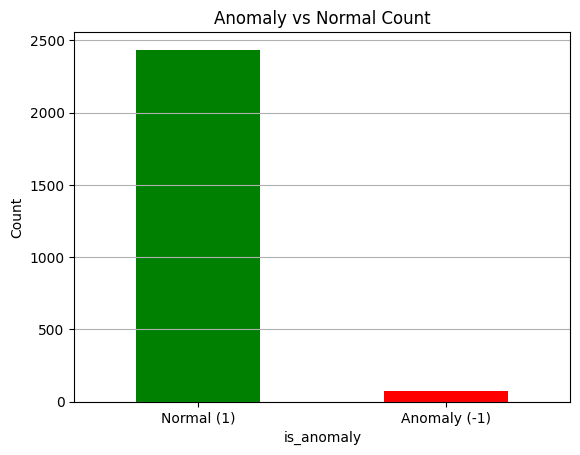

In [63]:
import matplotlib.pyplot as plt

df['is_anomaly'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.xticks(ticks=[0, 1], labels=['Normal (1)', 'Anomaly (-1)'], rotation=0)
plt.title("Anomaly vs Normal Count")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()

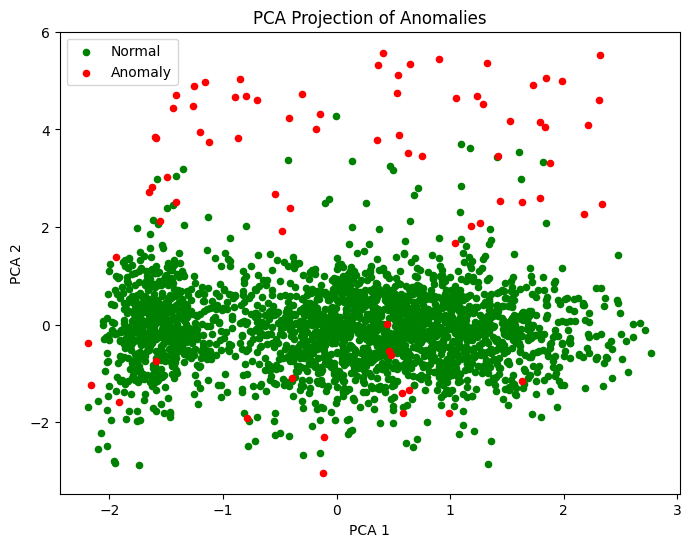

In [52]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[df['is_anomaly'] == 1, 0], X_pca[df['is_anomaly'] == 1, 1], 
            c='green', label='Normal', s=20)
plt.scatter(X_pca[df['is_anomaly'] == -1, 0], X_pca[df['is_anomaly'] == -1, 1], 
            c='red', label='Anomaly', s=20)
plt.title("PCA Projection of Anomalies")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()

In [53]:
for contamination in [0.01, 0.03, 0.05, 0.1]:
    model = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
    preds = model.fit_predict(X_scaled)
    print(f"Contamination={contamination:.2f} → Anomalies Detected: {(preds == -1).sum()}")

Contamination=0.01 → Anomalies Detected: 26
Contamination=0.03 → Anomalies Detected: 76
Contamination=0.05 → Anomalies Detected: 126
Contamination=0.10 → Anomalies Detected: 252


In [54]:
df = pd.read_csv('/kaggle/input/bank-transaction-dataset-for-fraud-detection/bank_transactions_data_2.csv')

df['TransactionHour'] = pd.to_datetime(df['TransactionDate']).dt.hour
df['DaysSinceLastTx'] = (
    pd.to_datetime(df['TransactionDate']) - pd.to_datetime(df['PreviousTransactionDate'])
).dt.total_seconds() / (60 * 60 * 24)

features = [
    'TransactionAmount',
    'TransactionDuration',
    'LoginAttempts',
    'AccountBalance',
    'CustomerAge',
    'TransactionHour',
    'DaysSinceLastTx'
]

X = df[features].fillna(0)

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [56]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.03)
df['is_anomaly'] = lof.fit_predict(X_scaled)  # -1 = anomaly, 1 = normal

In [57]:
# Count anomalies
print(df['is_anomaly'].value_counts())

# View anomaly examples
print(df[df['is_anomaly'] == -1].head())

# Optional: Save anomalies
df[df['is_anomaly'] == -1].to_csv("lof_anomalies.csv", index=False)

is_anomaly
 1    2436
-1      76
Name: count, dtype: int64
    TransactionID AccountID  TransactionAmount      TransactionDate  \
38       TX000039   AC00478             795.31  2023-10-12 17:07:40   
61       TX000062   AC00002             263.99  2023-05-16 16:07:30   
107      TX000108   AC00397             756.59  2023-03-06 16:47:02   
117      TX000118   AC00498              56.98  2024-01-01 16:34:10   
141      TX000142   AC00114            1049.92  2023-10-23 16:50:33   

    TransactionType       Location DeviceID     IP Address MerchantID Channel  \
38            Debit           Mesa  D000077   49.29.37.185       M048     ATM   
61            Debit         Dallas  D000285   7.146.35.122       M087  Branch   
107           Debit     Sacramento  D000028   174.61.77.54       M012  Branch   
117          Credit  Oklahoma City  D000256  101.90.40.193       M086     ATM   
141           Debit        Detroit  D000522  121.67.144.20       M052     ATM   

     CustomerAge CustomerOc

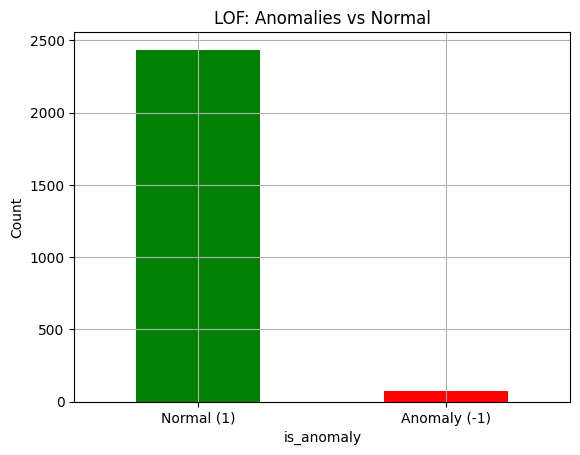

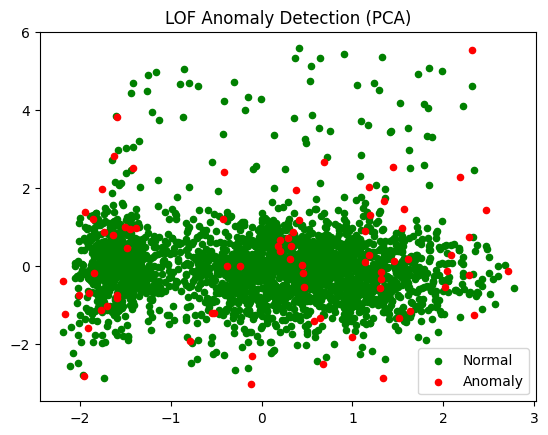

In [62]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Bar plot
df['is_anomaly'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.xticks(ticks=[0, 1], labels=['Normal (1)', 'Anomaly (-1)'], rotation=0)
plt.title("LOF: Anomalies vs Normal")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# 2D PCA scatter
X_pca = PCA(n_components=2).fit_transform(X_scaled)
plt.scatter(X_pca[df['is_anomaly'] == 1, 0], X_pca[df['is_anomaly'] == 1, 1],
            c='green', label='Normal', s=20)
plt.scatter(X_pca[df['is_anomaly'] == -1, 0], X_pca[df['is_anomaly'] == -1, 1],
            c='red', label='Anomaly', s=20)
plt.title("LOF Anomaly Detection (PCA)")
plt.legend()
plt.show()

In [59]:
for k in [5, 10, 20, 30, 50]:
    model = LocalOutlierFactor(n_neighbors=k, contamination=0.03)
    preds = model.fit_predict(X_scaled)
    count = (preds == -1).sum()
    print(f"k = {k}: Anomalies = {count}")

k = 5: Anomalies = 76
k = 10: Anomalies = 76
k = 20: Anomalies = 76
k = 30: Anomalies = 76
k = 50: Anomalies = 76
